In [313]:
from os import path as osp
import sys

import pandas as pd
import numpy as np
import quaternion
import random

from data_utils import CompiledSequence
from scipy.ndimage import gaussian_filter1d
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [342]:
class StridedSequenceDataset(Dataset):
    def __init__(self, seq_type, root_dir, data_list, cache_path=None, step_size=10, window_size=200, random_shift=0, transform=None, **kwargs):
        super(StridedSequenceDataset, self).__init__()
        self.feature_dim = seq_type.feature_dim
        self.target_dim = seq_type.target_dim
        self.aux_dim = seq_type.aux_dim
        self.window_size = window_size
        self.step_size = step_size
        self.random_shift = random_shift
        self.transform = transform
        self.interval = kwargs.get('interval', window_size)

        self.data_path = [osp.join(root_dir, data) for data in data_list]
        self.index_map = []
        self.ts, self.orientations, self.gt_pos = [], [], []
        self.features, self.targets, aux = [], [], []
        print(f"Strided Dataset created. Step_Size: {self.step_size}, Window_Size: {self.window_size}")
  
        for i in range(len(data_list)):
            seq = seq_type(osp.join(root_dir, data_list[i]), **kwargs)
            self.features.append(seq.get_feature())
            self.targets.append(seq.get_target())
            aux.append(seq.get_aux())
        
        
        for i in range(len(data_list)):            
            self.ts.append(aux[i][:, 0])
            self.orientations.append(aux[i][:, 1:5])
            self.gt_pos.append(aux[i][:, -3:])
            self.index_map += [[i, j] for j in range(0, self.targets[i].shape[0], step_size)]

        if kwargs.get('shuffle', True):
            random.shuffle(self.index_map)
            
        
    def __getitem__(self, item):
        
        seq_id, frame_id = self.index_map[item][0], self.index_map[item][1]
        
        if self.random_shift > 0:
            frame_id += random.randrange(-self.random_shift, self.random_shift)
            frame_id = max(self.window_size, min(frame_id, self.targets[seq_id].shape[0] - 1))

        frame_id = min(frame_id, self.targets[seq_id].shape[0] - self.window_size)
        feat = self.features[seq_id][frame_id:frame_id + self.window_size]
        targ = self.targets[seq_id][frame_id]
        #print(f"Features: {feat.shape}")
        #print(f"Targets: {targ}")

        if self.transform is not None:
            feat, targ = self.transform(feat, targ)

        return feat.astype(np.float32).T, targ.astype(np.float32), seq_id, frame_id

    def __len__(self):
        return len(self.index_map)

In [343]:
#modified for OXIOD dataset
from transformations import *
def get_dataset(root_dir, data_list, **kwargs):
    mode = kwargs.get('mode', 'train')

    random_shift, shuffle, transforms, grv_only = 0, False, None, False
    if mode == 'train':
        random_shift = 10 // 2
        shuffle = True
        transforms = RandomHoriRotate(math.pi * 2)
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True

    seq_type = OxfordGlobSpeedSequence
    dataset = StridedSequenceDataset(seq_type, root_dir, data_list, shuffle = shuffle, step_size = step_size)

    global _input_channel, _output_channel
    _input_channel, _output_channel = dataset.feature_dim, dataset.target_dim
    return dataset


def get_dataset_from_list(root_dir, list_path, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list, **kwargs)

In [344]:
def recon_traj_with_preds(dataset, preds, seq_id=0, **kwargs):
    """
    Reconstruct trajectory with predicted global velocities.
    """
    ts = dataset.ts[seq_id]
    ind = np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=np.int32) # Gets an array of frame IDs which correspond to the sequence
    dts = 0.01
    # #dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])
    # print(f'The mean dts: {dts}') #to remove
    # print(f'pred shape: {preds.shape}') #to remove
    # print(f' dataset shape: {len(dataset)}') #to remove
    # print(f' dataset.ts shape: {len(dataset)}') #to remove
    pos = np.zeros([preds.shape[0] + 2, 2])
    # initial position using first position value
    pos[0] = dataset.gt_pos[seq_id][0, :2]
    
    # the intermediate positions using the time interval and adding to initial position
    pos[1:-1] = np.cumsum(preds[:, :2] * dts, axis=0) + pos[0]
    pos[-1] = pos[-2]
    
    # # This does interpolation because we do not have positions for every timestep. [ts[0] +/- 1e-06] corresponds to the end with an additional small value
    # ts_ext = np.concatenate([[ts[0] - 1e-06], ts[ind], [ts[-1] + 1e-06]], axis=0)
    # pos = interp1d(ts_ext, pos, axis=0)(ts)
    return pos

In [403]:
class OxfordGlobSpeedSequence(CompiledSequence):
    """
    Dataset :- Oxford (can be downloaded from https://drive.google.com/file/d/1UCHY3ENCybcBNyiC2wx1gQEWSLqzJag0/view)
    Features :- raw angular rate and acceleration (includes gravity).
    """
    feature_dim = 6
    target_dim = 2
    aux_dim = 8

    def __init__(self, data_path=None, **kwargs):
        super().__init__(**kwargs)
        self.ts, self.features, self.targets, self.orientations, self.gt_pos = None, None, None, None, None

        self.w = kwargs.get('interval', 1) #default interval will be one, if 'interval' is not given
        if data_path is not None:
            self.load(data_path)

    def load(self, data_path):
        if data_path[-1] == '/':
            data_path = data_path[:-1]
        
        data = pd.read_csv(data_path)
        display(data)
        column_names = ['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)','rotation_rate_z(radians/s)', 'user_acc_x(G)', 'user_acc_y(G)',
                        'user_acc_z(G)', 'translation.x', 'translation.y', 'translation.z', 'rotation.x', 'rotation.y', 'rotation.z', 'rotation.w']

        data.columns = column_names
        
        data = self.clean_Data(data)
        # Print the modified DataFrame
        #display(data)
        
        
        gyro = data[['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)']].values
        #convert acceleration into metre per second square instead of in terms of gravity
        data[['user_acc_x(m/s2)', 'user_acc_y(m/s2)', 'user_acc_z(m/s2)']] = data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']] * 9.81
        acce = data[['user_acc_x(m/s2)', 'user_acc_y(m/s2)', 'user_acc_z(m/s2)']].values
        
        #Add in the time data. The time data will be an estimate based on the fact that the frequency of IMU sampling (100Hz)
        time_arr = np.linspace(0, len(data)*0.01, num = len(data))
        data['Time(s)'] = time_arr
        ts = time_arr
        gt_pos = data[['translation.x', 'translation.y', 'translation.z']].values
        
        dt = (ts[self.w:] - ts[:-self.w])[:, None]
        print(self.w, 'is my window')
        print(dt)
        glob_v = (gt_pos[self.w:] - gt_pos[:-self.w]) / dt #global velocity that takes displacement divide by time
        #plt.plot(np.linspace(0, glob_v.shape[0],glob_v.shape[0]), glob_v[:,1])
        print('before')
        print('target shape:' , glob_v.shape)
        print('target min: ', np.min(glob_v))
        
        outlier_index = np.argwhere(np.logical_or(glob_v >= 5, glob_v <= -5))
        print(outlier_index[:, 0])
        for index in outlier_index:
            idx = index[0]
            glob_v_slice = glob_v[idx:idx + 5, index[1]]
            avg_slice = (np.average(glob_v_slice) + np.average(glob_v[idx - 5:idx, index[1]])) / 2
            glob_v[idx, index[1]] = avg_slice

        print('after')
        print('target shape:' , glob_v.shape)
        plt.plot(np.linspace(0, glob_v.shape[0],glob_v.shape[0]), glob_v[:,1])
        print('target min: ', np.min(glob_v))
        

        
        # Right now, ori_q is using the ground truth rotation quaternion
        ori = data[['rotation.x', 'rotation.y', 'rotation.z', 'rotation.w']]
        ori_q = quaternion.from_float_array(ori)
        
        #convert to quaternion in order to do quaternion operation, through padding of zeroes. The new quaternion will then have the pads removed 
        gyro_q = quaternion.from_float_array(np.concatenate([np.zeros([gyro.shape[0], 1]), gyro], axis=1))
        acce_q = quaternion.from_float_array(np.concatenate([np.zeros([acce.shape[0], 1]), acce], axis=1))
        glob_gyro = quaternion.as_float_array(ori_q * gyro_q * ori_q.conj())[1:, 1:]
        glob_acce = quaternion.as_float_array(ori_q * acce_q * ori_q.conj())[1:, 1:]

        start_frame = 0
        self.ts = ts[start_frame:]
        self.features = np.concatenate([glob_gyro, glob_acce], axis=1)[start_frame:]
        self.targets = glob_v[start_frame:, :2]
        self.orientations = quaternion.as_float_array(ori_q)[start_frame:]
        self.gt_pos = gt_pos[start_frame:]
        
        # print(f'timestamp: {self.ts.shape}')
        # print(f'features: {self.features.shape}')
        # print(f'targets: {self.targets.shape}')
        # print(f'orientations: {self.orientations.shape}')
        # print(f'gt_pos: {self.gt_pos.shape}')
        # print("===================================================")
        # print()

    def clean_Data(self, data):
        def split_consecutive_numbers(lst):
            sublists = []
            sublist = []

            for i in range(len(lst)):
                if not sublist or lst[i] == sublist[-1] + 1:
                    sublist.append(lst[i])
                else:
                    sublists.append(sublist)
                    sublist = [lst[i]]

            if sublist:
                sublists.append(sublist)

            return sublists
        #remove na values
        data.dropna()
        #remove values that were not recorded properly, namely those that are at position (0,0,0) even after two seconds
        indexes = data[(data['translation.x'] == 0) & (data['translation.y'] == 0) & (data.index >= 200)].index
        sublists = split_consecutive_numbers(indexes)
        for sublist in sublists:
            first_index = sublist[0]
            last_index = sublist[-1]
            data['translation.x'].iloc[sublist] = np.linspace(data['translation.x'][first_index-1], data['translation.x'][last_index+1], len(sublist))
            data['translation.y'].iloc[sublist] = np.linspace(data['translation.y'][first_index-1], data['translation.y'][last_index+1], len(sublist))
        return data
    
    def get_feature(self):
        return self.features

    def get_target(self):
        print('target min: ', np.min(self.targets))
        return self.targets

    def get_aux(self):
        aux = np.concatenate([self.ts[:, None], self.orientations, self.gt_pos], axis=1)
        return aux

    # def get_meta(self):
    #     return '{}: device: {}, ori_error ({}): {:.3f}'.format(
    #         self.info['path'], self.info['device'], self.info['ori_source'], self.info['source_ori_error'])

Strided Dataset created. Step_Size: 10, Window_Size: 200


,rotation_rate_x(radians/s),rotation_rate_y(radians/s),rotation_rate_z(radians/s),user_acc_x(G),user_acc_y(G),user_acc_z(G),translation.x,translation.y,translation.z,rotation.x,rotation.y,rotation.z,rotation.w
0,-0.004726,0.008829,0.013567,0.000282,-0.005577,0.004880,0.039513,-0.009500,-0.010468,0.746280,0.001590,0.011668,0.665530
1,-0.015530,-0.008131,0.013578,0.003200,-0.004955,0.001632,0.039344,-0.009437,-0.010466,0.746320,0.001626,0.011708,0.665480
2,-0.010328,-0.029477,0.006153,0.004059,-0.003926,0.002983,0.039179,-0.009379,-0.010468,0.746370,0.001651,0.011743,0.665420
3,-0.000814,-0.046594,-0.003407,0.006982,-0.000938,0.004708,0.039019,-0.009319,-0.010475,0.746410,0.001664,0.011772,0.665380
4,0.015157,-0.052051,-0.005505,0.004759,0.001311,0.003400,0.038864,-0.009253,-0.010487,0.746430,0.001672,0.011790,0.665360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,NaN,NaN,NaN,NaN,NaN,NaN,-1.899700,0.304790,0.163740,0.005961,-0.755940,-0.654280,0.021079
16212,NaN,NaN,NaN,NaN,NaN,NaN,-1.899700,0.304780,0.163660,0.005951,-0.756030,-0.654170,0.021045
16213,NaN,NaN,NaN,NaN,NaN,NaN,-1.899700,0.304750,0.163570,0.005934,-0.756120,-0.654070,0.021004
16214,NaN,NaN,NaN,NaN,NaN,NaN,-1.899700,0.304750,0.163570,0.005934,-0.756120,-0.654070,0.021004


1 is my window
[[0.01000062]
 [0.01000062]
 [0.01000062]
 ...
 [0.01000062]
 [0.01000062]
 [0.01000062]]
before
target shape: (16215, 3)
target min:  -66.8458775284001
[2638 3657 5326 9393 9416 9519 9720 9724 9753 9753 9783 9783 9792 9823
 9823 9823 9843 9843 9848 9883 9953 9953]
after
target shape: (16215, 3)
target min:  -5.276674580664187
target min:  -5.276674580664187


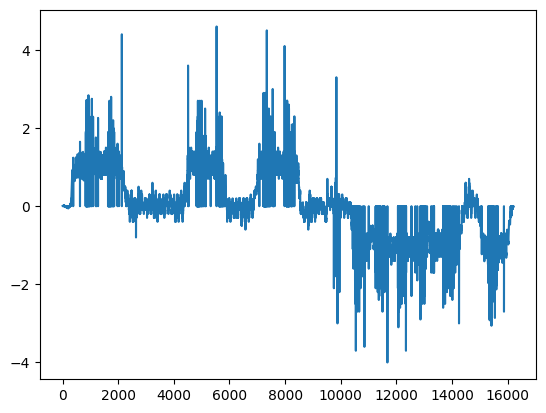

In [404]:
from torch.utils.data import DataLoader
step_size = 10
train_dataset = get_dataset('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/large scale', ['floor4/combined3.csv'], mode='test', step_size = step_size, window_size = 200)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, drop_last = True)

In [405]:
np.max(train_dataset.targets)

4.969693512582589

In [406]:
targ_all = []
for bid, (feat, targ, _, _) in enumerate(train_loader):
    #print(targ)
    targ_all.append(targ.detach().numpy())
targ_all = np.concatenate(targ_all, axis=0)

In [407]:
targ_all.shape

(1536, 2)

In [408]:
np.max(targ_all)

4.8097034

In [400]:
index = np.argwhere(targ_all == np.min(targ_all))
print(index)
print(np.min(targ_all))

[[329   0]
 [341   0]]
-2.6998334


ValueError: x and y must have same first dimension, but have shapes (43640,) and (16215,)

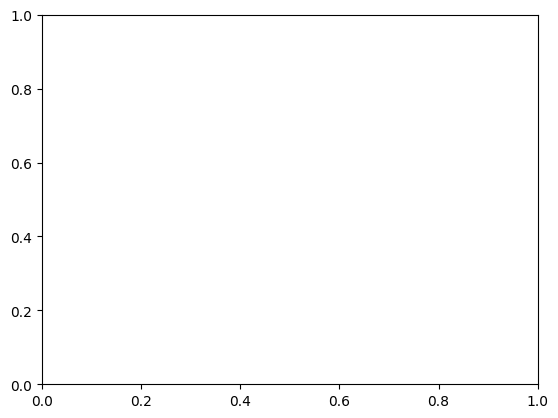

In [401]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, 43640,43640), glob_v[:,0])

In [325]:
from scipy.interpolate import interp1d
pos_pred = recon_traj_with_preds(train_dataset, np.array(targ_all))[:, :2]
pos_gt = train_dataset.gt_pos[0][:, :2]

In [326]:
pos_pred

array([[ 0.039513  , -0.0094998 ],
       [ 0.03934401, -0.009437  ],
       [ 0.03922602, -0.00931671],
       ...,
       [ 0.33765406,  1.02660786],
       [ 0.33735407,  1.01510857],
       [ 0.33735407,  1.01510857]])

In [328]:
pos_gt

array([[ 0.039513 , -0.0094998],
       [ 0.039344 , -0.009437 ],
       [ 0.039179 , -0.0093787],
       ...,
       [-1.8997   ,  0.30475  ],
       [-1.8997   ,  0.30475  ],
       [-1.8997   ,  0.30464  ]])

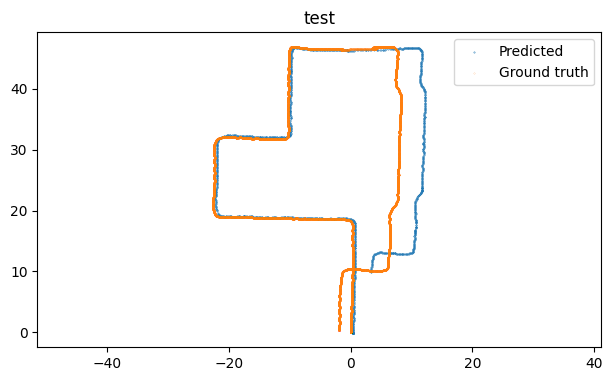

In [332]:
import matplotlib.pyplot as plt
kp = 2
plt.figure('{}'.format('Test'), figsize=(16, 9))
plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
plt.scatter(pos_pred[:, 0], pos_pred[:, 1], s=0.1)
plt.scatter(pos_gt[:, 0], pos_gt[:, 1], s = 0.01)
plt.title('test')
plt.axis('equal')
plt.legend(['Predicted', 'Ground truth'])

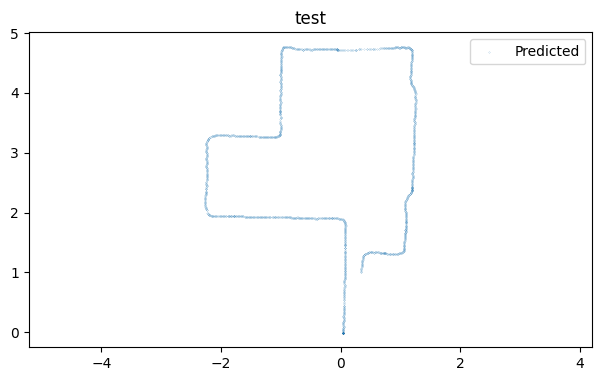

In [330]:
import matplotlib.pyplot as plt
kp = 2
plt.figure('{}'.format('Test'), figsize=(16, 9))
plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
plt.scatter(pos_pred[:, 0], pos_pred[:, 1], s=0.01)
#plt.scatter(pos_gt[:, 0], pos_gt[:, 1], s = 0.1)
plt.title('test')
plt.axis('equal')
plt.legend(['Predicted', 'Ground truth'])